# Tutorial

## Preliminaries

The following set of examples shows the user how to train a Masked Autoregressive Flow (MAF) and an example Kernel Density Estimator (KDE). We further demonstrate how to use `margarine` to estimate the Kullback Leibler divergence and Bayesian Dimensionality with the trained MAF and KDE.

The code requires [anesthetic](https://pypi.org/project/anesthetic/) to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic.samples import NestedSamples

In order to demonstrate the applications of the code we need to load some example samples from a nested sampling run and we can visualise the posterior distributions with `anesthetic`. We write a helper function to load the chains and transform the parameters in the first three columns, which were generated with a log-uniform prior, into the unifrom parameter space.

`margarine` currently assumes that the parameters are uniformly distributed when calculating the KL divergence and bayesian dimensionality. It is therefore important to transform the parameters into the uniform parameter space before we train our MAF and KDE.

In [2]:
def load_chains(root):
    """
    Function uses anesthetic to load in a set of chains and returns
    the pandas table of samples, a numpy
    array of the parameters in the uniform space and weights.
    """

    samples = NestedSamples(root=root)

    try:
        names = ['p' + str(i) for i in range(ndims)]
        theta = samples[names].values
    except:
        names = [i for i in range(ndims)]
        theta = samples[names].values

    weights = samples.weights

    return samples, theta, weights

ndims=5

root = '../tests/test_samples/test'
samples, theta, weights = load_chains(root)


To visualise the posterior we define another helper function that will be useful later in the notebook.

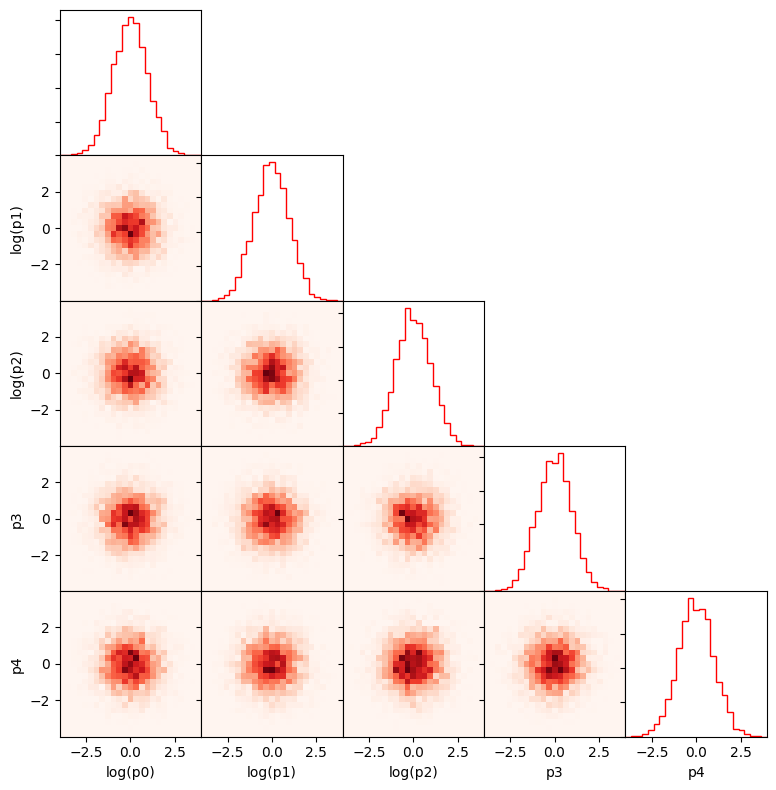

In [3]:
from anesthetic.plot import hist_plot_1d, hist_plot_2d

def plotter(theta, names, w=None, ndims=5):
    """ Helper function that uses anesthetic to produce corner plots """
    fig, axes = plt.subplots(ndims, ndims, figsize=(8, 8), sharex='col')
    for i in range(ndims):
        for j in range(ndims):
            if i < j:
                axes[i, j].axis('off')
            if i == j:
                hist_plot_1d(axes[i, j], theta[:, i], weights=w,
                xmin=theta[:, i].min(), xmax=theta[:, i].max(), color='r',
                histtype='step', bins=25, density=True)
            if i < j:
                hist_plot_2d(axes[j, i], theta[:, i], theta[:, j],
                            weights=w,
                            xmin=theta[:, i].min(), xmax=theta[:, i].max(),
                            ymin=theta[:, j].min(), ymax=theta[:, j].max(),
                            bins=25, density=True, cmap=plt.get_cmap('Reds'))
            if j not in set([0, ndims]):
                axes[i, j].set_yticklabels([])
            if j == 0:
                if i == 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(names[i])
            if i == ndims-1:
                axes[i, j].set_xlabel(names[j])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

names = ['log(p' + str(i) + ')' if i in [0, 1, 2] else 'p' + str(i) for i in range(ndims)]
plotter(theta, names, weights)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `margarine`. To train the MAF we first need to initalise the class with the samples and corresponding weights.

In [4]:
import os
os.chdir('../')

from margarine.maf import MAF
from margarine.kde import KDE

bij = MAF(theta, weights)
bij.train(100)

We can then generate samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

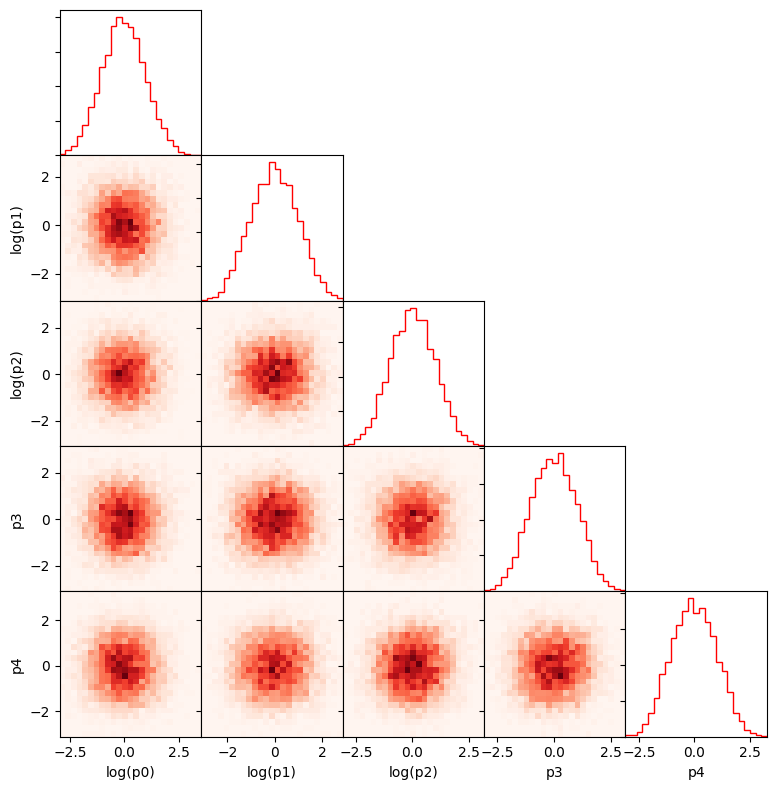

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(theta), theta.shape[-1])))

plotter(x, names)

Alternatively we can generate samples with the following code which takes in an integer and returns an array of shape (int, 5). The `.sample()` function is a proxy for `__call__`.

In [6]:
x = bij.sample(5000)

We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. 

The samples presented here were generated using a gaussian likelihood and fitting with nested sampling for 5 parameters. We can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for the samples for comparison. We see very similar results and note that the similarity improves with the number of epochs.

In [7]:
from margarine.marginal_stats import calculate

stats = calculate(bij).statistics()
print(stats.iloc[0, 0], samples.D())
print(stats.iloc[1, 0], samples.d())

3.310774486919951 3.3308079438366938
4.839712964526534 5.013952162478263


/Users/harry/Documents/margarine/margarine/marginal_stats.py:72: UserWarning: If prior samples are not provided the prior is assumed to be uniform and the posterior samples are are assumed to be from the same uniform space.
  warnings.warn('If prior samples are not provided the prior is ' +
/Users/harry/Documents/margarine/margarine/marginal_stats.py:194: FutureWarning: The 'inplace' keyword in DataFrame.set_index is deprecated and will be removed in a future version. Use `df = df.set_index(..., copy=False)` instead.
  results.set_index('Statistic', inplace=True)


We could imagine that the above set of parameters is a sub-sample of perhaps signal parameters that we are interested in and having marginalised out the nuisance parameters we can use `margarine` to determine how well constrained the sub-space is.

As an example we can train a MAF on three of the parameters in this distribution.

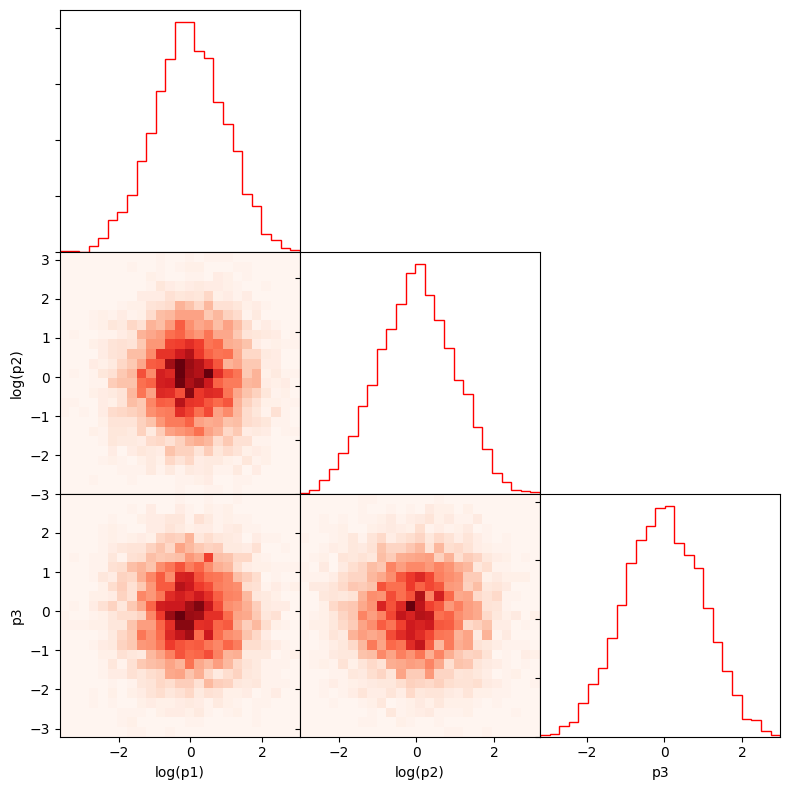

                  Value  Lower Bound  Upper Bound
Statistic                                        
KL Divergence  1.994334     1.992596     1.997777
BMD            2.804455     2.562036     3.311070


/Users/harry/Documents/margarine/margarine/marginal_stats.py:72: UserWarning: If prior samples are not provided the prior is assumed to be uniform and the posterior samples are are assumed to be from the same uniform space.
  warnings.warn('If prior samples are not provided the prior is ' +
/Users/harry/Documents/margarine/margarine/marginal_stats.py:194: FutureWarning: The 'inplace' keyword in DataFrame.set_index is deprecated and will be removed in a future version. Use `df = df.set_index(..., copy=False)` instead.
  results.set_index('Statistic', inplace=True)


In [8]:
theta_reduced = theta[:, 1:-1]
names_reduced = names[1:-1]

bij = MAF(theta_reduced, weights)
bij.train(100)
x = bij.sample(5000)

plotter(x, names_reduced, ndims=3)

stats = calculate(bij).statistics()
print(stats)

# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

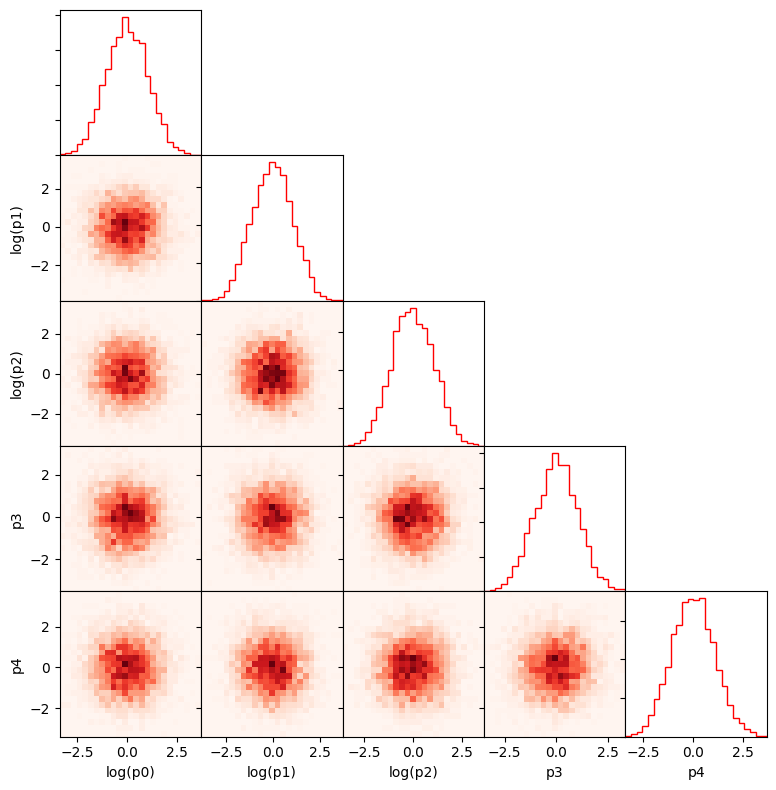

/Users/harry/Documents/margarine/margarine/marginal_stats.py:72: UserWarning: If prior samples are not provided the prior is assumed to be uniform and the posterior samples are are assumed to be from the same uniform space.
  warnings.warn('If prior samples are not provided the prior is ' +


3.609496187306833 +(-) 0.2765981957821131 ( 0.48614620453886204 ) 3.3308079438366938
1.913573635193844 +(-) 2.048906422381939 ( 0.5664883865810604 ) 5.013952162478263


/Users/harry/Documents/margarine/margarine/marginal_stats.py:194: FutureWarning: The 'inplace' keyword in DataFrame.set_index is deprecated and will be removed in a future version. Use `df = df.set_index(..., copy=False)` instead.
  results.set_index('Statistic', inplace=True)


In [9]:
from margarine.kde import KDE
kde = KDE(theta, weights)
kde.generate_kde()
x = kde.sample(5000)

plotter(x, names)

stats = calculate(kde).statistics()
print(stats.iloc[0, 0], '+(-)', stats.iloc[0, 2] - stats.iloc[0, 0], 
      '(', stats.iloc[0, 0] - stats.iloc[0, 1], ')', samples.D())
print(stats.iloc[1, 0], '+(-)', stats.iloc[1, 2] - stats.iloc[1, 0], 
      '(', stats.iloc[1, 0] - stats.iloc[1, 1], ')', samples.d())

Rather than using the `kde.sample()` function to generate samples we could transform samples from the hypercube with the following code and the `__call__()` function. However, we note that this is a much slower method of generating samples as it is designed to be bijective. Transformation from the hypercube is useful if we would like to use a trained KDE or MAF as the prior in a subseqeunt nested sampling run however is not necessary if we simply want to calcualte marginal Bayesian statistics.

In [10]:
x = kde(np.random.uniform(0, 1, size=(10, theta.shape[-1])))
print(x)

[[ 0.00866746 -1.3674294  -1.04610725  0.74177354  0.59200377]
 [ 1.25609155 -1.55385202  0.17241134  1.7487886  -0.85378741]
 [-0.42623049 -1.28543977  0.6308928  -0.95923815 -0.5000081 ]
 [-0.91927021  1.82074337 -1.4875557   1.13219455  1.80085807]
 [-0.43319482  0.51338045 -0.58847524 -1.32000678  2.11012111]
 [-0.48190147  0.53976851 -0.73276747  0.63523436  1.8162574 ]
 [ 0.3549924  -0.13545207  1.38762986 -1.22339099  1.09403153]
 [-0.51115334  0.47585545 -0.88141388  2.62513102 -0.1775158 ]
 [ 0.28904819 -0.26387664  0.80479892  0.02123311 -0.50959412]
 [ 0.88906095 -1.04406146 -1.67107321 -1.62705777 -0.03433262]]
